# Ku et.al. configuration - finding a good set of modular coils

* QH configuration
* 5-field period
* Aspect ratio is 10
* Mean iota is 1.19

In [34]:
from simsopt.mhd import Vmec
from simsopt.geo import SurfaceRZFourier, CurveHelical
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib widget

In [35]:
v = Vmec('wout_ku5_v444_b586.nc')
nfp = v.boundary.nfp

In [3]:
surf = SurfaceRZFourier( nfp=nfp, stellsym=True, mpol=v.boundary.mpol, ntor=v.boundary.ntor, quadpoints_phi=np.linspace(0,2*np.pi/nfp,128,endpoint=False), quadpoints_theta=np.linspace(0,2*np.pi,64,endpoint=False))

for mm in range(0,surf.mpol+1):
    for nn in range(-surf.ntor,surf.ntor+1):
        if mm==0 and nn<0:
            continue
        surf.set(f'rc({mm},{nn})', v.boundary.get(f'rc({mm},{nn})'))
        if mm==0 and nn==0:
            continue
        surf.set(f'zs({mm},{nn})', v.boundary.get(f'zs({mm},{nn})'))

surf = v.boundary

In [37]:
v.boundary.volume()

443.9999999999981

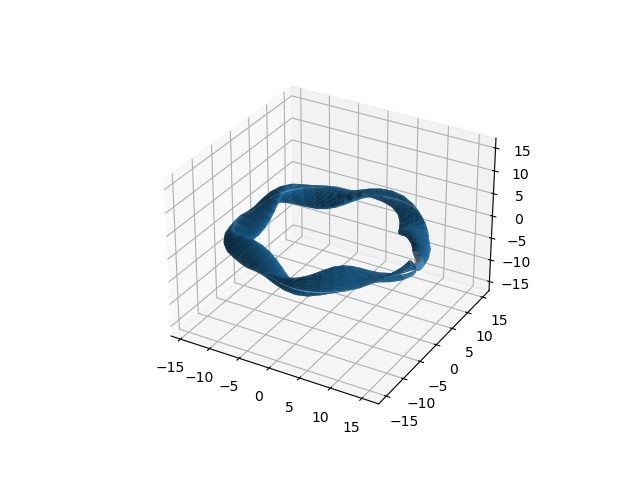

<Axes3D: >

In [4]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf.plot(ax=ax, close=False)

In [5]:
v.aspect()

10.010697281704402

In [6]:
v.mean_iota()

1.1924833357523381

# Coil constraints

We infer constrains on coils geometry from the ARIES-CS design - see the paper "1 # Neutronics Characteristics, Shielding System, Activation and Environmental Aspects of ARIES-ACT-2 Power Plant"

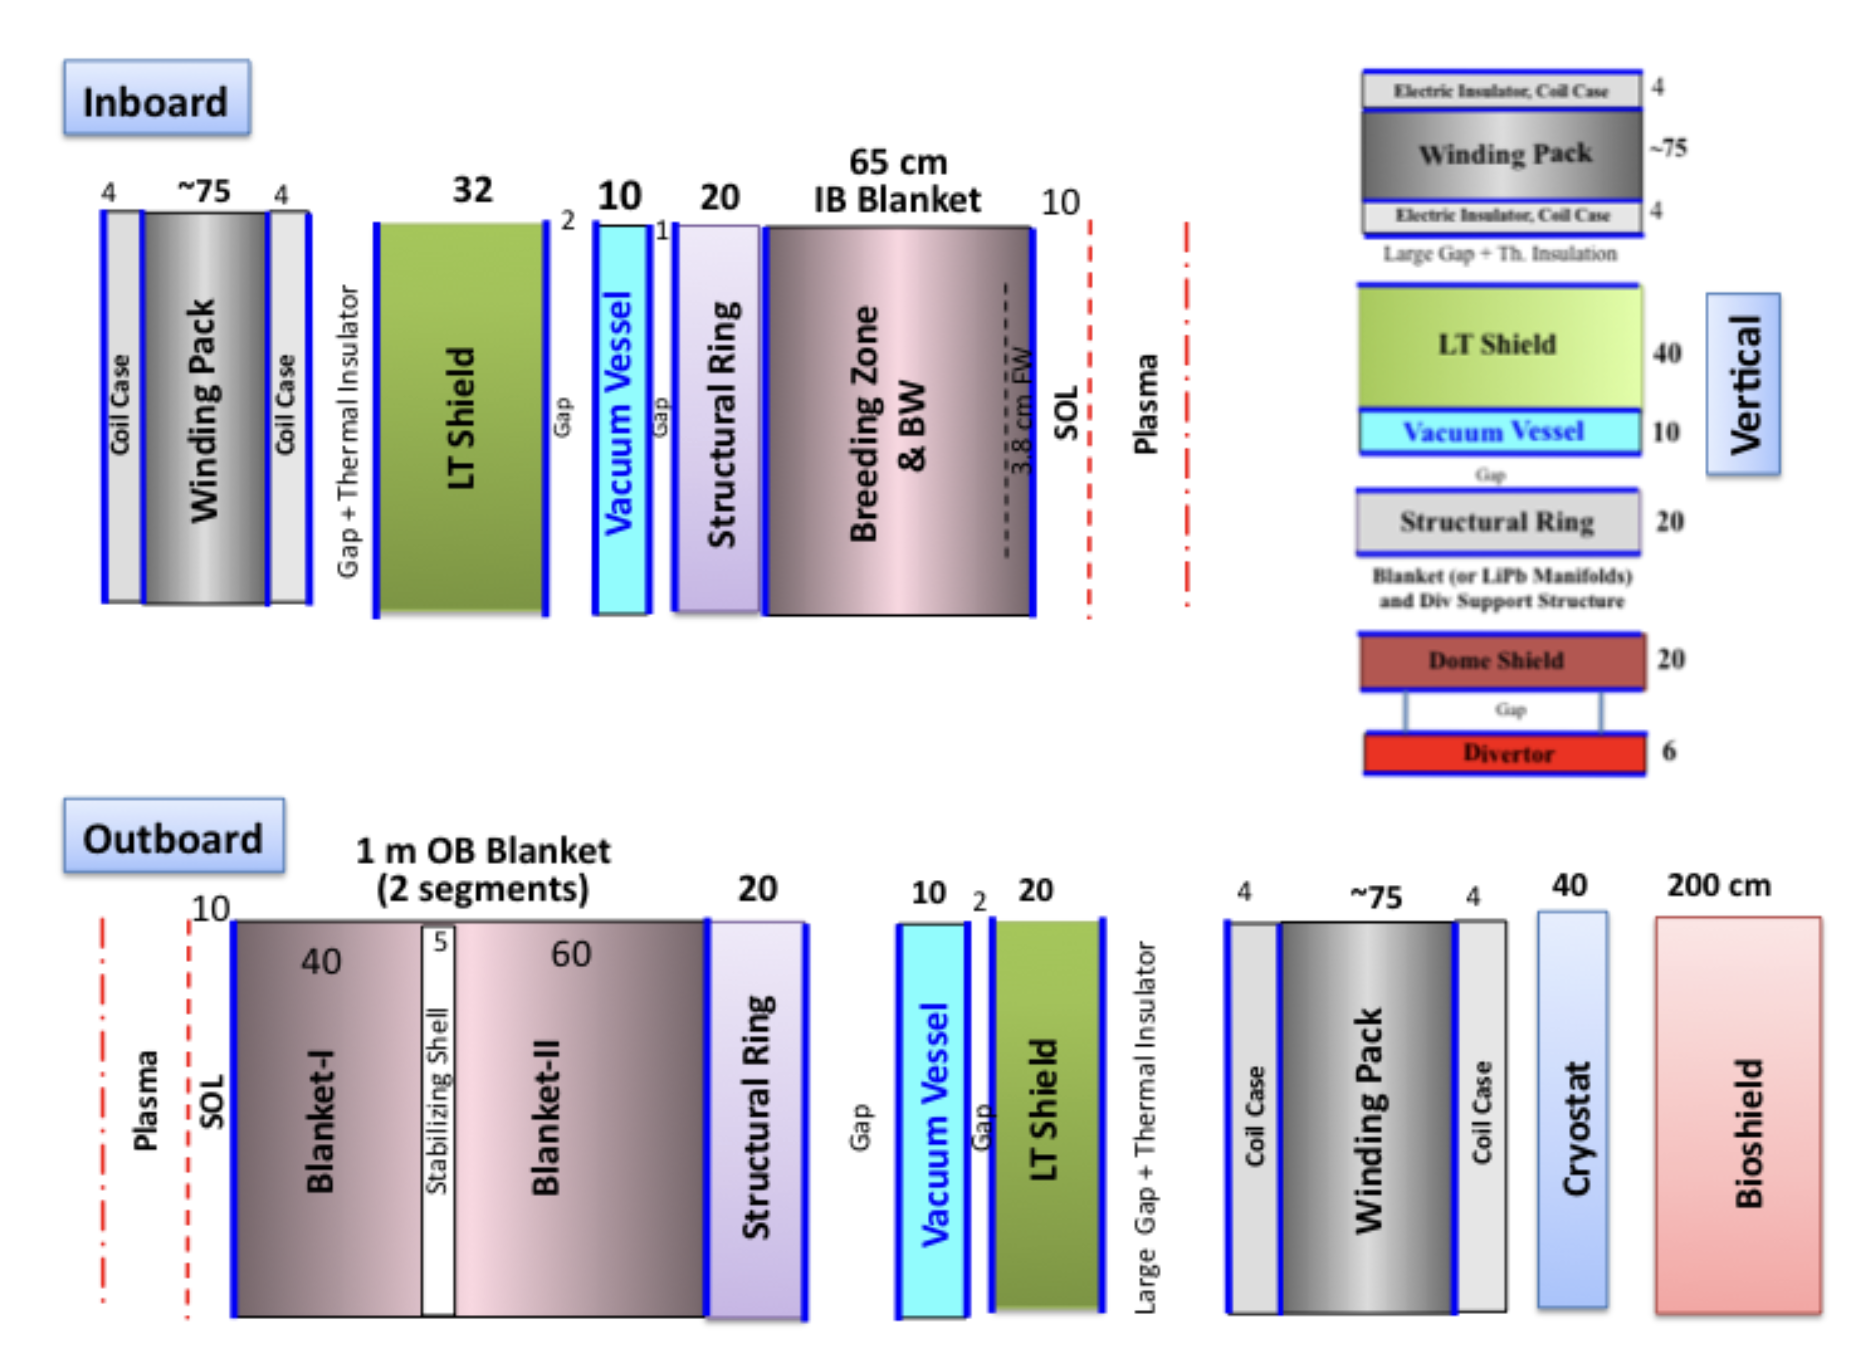

In [7]:
from simsopt.geo import CurveLength, CurveCurveDistance, MeanSquaredCurvature, LpCurveCurvature
from simsopt.geo import curves_to_vtk, create_equally_spaced_curves, CurveSurfaceDistance, ToroidalFlux
from simsopt.field.coil import apply_symmetries_to_currents, apply_symmetries_to_curves, ScaledCurrent
from simsopt.objectives import SquaredFlux, QuadraticPenalty
from simsopt.field import BiotSavart, Current
from simsopt.field.coil import Coil
from simsopt.util import MpiPartition
from scipy.optimize import minimize
from simsopt._core.optimizable import Optimizable

In [8]:
#CC_dist = 0.83 # based on 83cm winding pack size + 20% margin
CC_dist = 0.5 # based on 83cm winding pack size + 20% margin
wcc = 1
#CS_dist = 1.4 # based on blanket, structure, vessel, LT shield, gaps
CS_dist = 0.4
wcs = 1
Length = 2*np.pi*v.boundary.minor_radius() * 4 # Educated guess based on minor radius of the plasma boundary
wl = 1e-5

tflux = -1
wtfl = 1

ncoils = 3

# max curvature?
# mean curvature?
# max current?

In [9]:
base_curves = create_equally_spaced_curves( ncoils, nfp, True, R0=v.boundary.major_radius(), R1=v.boundary.minor_radius()*3, order=10 )
full_curves = apply_symmetries_to_curves( base_curves, nfp, True )

base_currents = [Current(1) for c in base_curves]
full_currents = [ScaledCurrent(c, 1e5) for c in apply_symmetries_to_currents( base_currents, nfp, True )]

# hcurve = CurveHelical( 128, 2, n0=nfp, l0=1, R0=12, r0=5 )
# hcoil = Coil( hcurve, ScaledCurrent(Current(1), 1e5) )

coils = [Coil(curve, current) for curve, current in zip(full_curves, full_currents)] #+ [hcoil]
bs = BiotSavart( coils )
bs2 = BiotSavart( coils )
bs.set_points(surf.gamma().reshape((-1,3)))

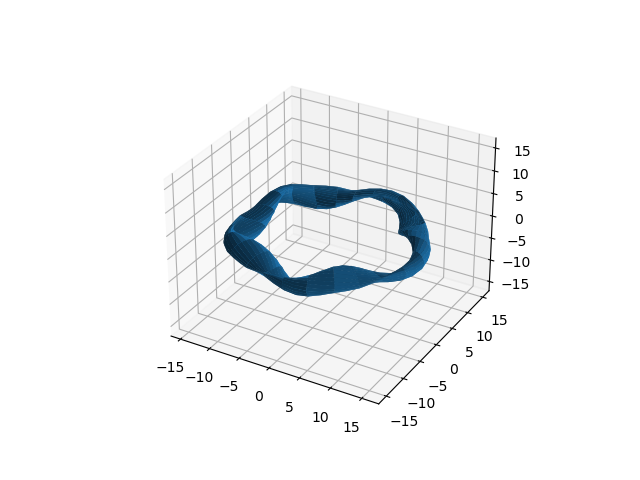

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf.plot(ax=ax, close=True)
for c in full_curves:
    c.plot(ax=ax, show=False)

In [22]:
sqflux = SquaredFlux( surf, bs, definition='quadratic flux' )
torflux = QuadraticPenalty( ToroidalFlux( surf, bs2 ), tflux, 'identity' )
lengths = [QuadraticPenalty( CurveLength(curve), Length, f='max' ) for curve in base_curves]
cc_penalty = CurveCurveDistance( full_curves, CC_dist, len(full_curves) )
cs_penalty = CurveSurfaceDistance( base_curves, surf, CS_dist )


JF = 1e2*sqflux + wl * np.sum(lengths) + wcc*cc_penalty + wcs*cs_penalty + wtfl * torflux

In [23]:
torflux.J()

0.0015535667122364538

In [24]:
print(f'Original squared flux penalty is {sqflux.J()}')
print(f'Max length is {Length}, starting length is {lengths[0].J()}')
print(f'Min coil-coil distance is {CC_dist}, starting minimum distance is {cc_penalty.shortest_distance()}')
print(f'Min plasma-coil distance is {CS_dist}, starting minimum distance is {cs_penalty.shortest_distance()}')
print(f'Original target function is {JF.J()}')

Original squared flux penalty is 0.0283106203636222
Max length is 32.918206083592466, starting length is 43.1426360942748
Min coil-coil distance is 0.5, starting minimum distance is 0.4951497887255375
Min plasma-coil distance is 0.4, starting minimum distance is 0.34777850735978494
Original target function is 2.8339256131880073


In [25]:
JF.fix_all()

for current in base_currents:
    current.unfix_all()
base_currents[0].fix_all()

def fun(x, info):
    JF.x = x
    info['Nfeval'] += 1
    J = JF.J()
    dJ = JF.dJ()
    if np.mod(info['Nfeval'],10)==0:
        nf = info['Nfeval']
        print(f'Evaluation #{nf}: J={J}, max(|dJ|)={np.max(np.abs(dJ))}')
    return J, dJ

In [26]:
for order in [1,2,3]:
    for curve in base_curves:
        for ii in range(0,order):
            curve.unfix(f'xc({ii})')
            curve.unfix(f'yc({ii})')
            curve.unfix(f'zc({ii})')
            if ii>0:
                curve.unfix(f'xs({ii})')
                curve.unfix(f'ys({ii})')
                curve.unfix(f'zs({ii})')
    
    options={'maxiter': 100, 'maxcor': 300}
    dofs = JF.x
    print(f'OPTIMIZATION FOR ORDER={order}\n')
    res = minimize(fun, dofs, jac=True, method='L-BFGS-B', args=({'Nfeval':0}), options=options, tol=1e-12)
    print(res.message)
    print(f'Optimized squared flux penalty is {sqflux.J()}')
    print(f'Max length is {Length}, optimized length is {lengths[0].J()}')
    print(f'Min coil-coil distance is {CC_dist}, optimized minimum distance is {cc_penalty.shortest_distance()}')
    print(f'Min plasma-coil distance is {CS_dist}, optimized minimum distance is {cs_penalty.shortest_distance()}')
    print(f'Final target function is {JF.J()}')
    print(f'============================================\n\n')

OPTIMIZATION FOR ORDER=1

Evaluation #10: J=0.6526164475148541, max(|dJ|)=0.35031022204285667
Evaluation #20: J=0.5775678975118641, max(|dJ|)=0.07739443658078407
Evaluation #30: J=0.5112131238474492, max(|dJ|)=0.052053837391973744
Evaluation #40: J=0.4963780040963834, max(|dJ|)=0.02007120931342439
Evaluation #50: J=0.4877778314911915, max(|dJ|)=0.02672161824756542
Evaluation #60: J=0.47886487200385186, max(|dJ|)=0.03030667745498352
Evaluation #70: J=0.4741085709193106, max(|dJ|)=0.05220916733706303
Evaluation #80: J=0.46918374907221383, max(|dJ|)=0.035240371433428355
Evaluation #90: J=0.46866173739886474, max(|dJ|)=0.002709763017385264
Evaluation #100: J=0.4683488730774068, max(|dJ|)=0.001529040632503531
Evaluation #110: J=0.468331656102957, max(|dJ|)=3.1311512511904456e-05
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Optimized squared flux penalty is 0.0005784891086587353
Max length is 32.918206083592466, optimized length is 43.1426360942748
Min coil-coil distance is 0.5, optimized

In [27]:
bs.save( "bs_output.json") 

'{\n  "@module": "simsopt._core.json",\n  "@class": "SIMSON",\n  "@version": "0.19.0.post0+gc859dfb3.d20230815.dirty",\n  "graph": {\n    "$type": "ref",\n    "value": "BiotSavart1"\n  },\n  "simsopt_objs": {\n    "5911385280": {\n      "@module": "simsopt._core.optimizable",\n      "@class": "DOFs",\n      "@name": "5911385280",\n      "@version": "0.19.0.post0+gc859dfb3.d20230815.dirty",\n      "x": {\n        "@module": "numpy",\n        "@class": "array",\n        "dtype": "float64",\n        "data": [\n          14.34244519460128,\n          0.30590449183196133,\n          1.8310266504030133,\n          0.17127243326528563,\n          0.5620180830789967,\n          0.0,\n          0.0,\n          0.0,\n          0.0,\n          0.0,\n          0.0,\n          0.0,\n          0.0,\n          0.0,\n          0.0,\n          0.0,\n          0.0,\n          0.0,\n          0.0,\n          0.0,\n          0.0,\n          0.8440831626207475,\n          -0.7480693320189752,\n          1.

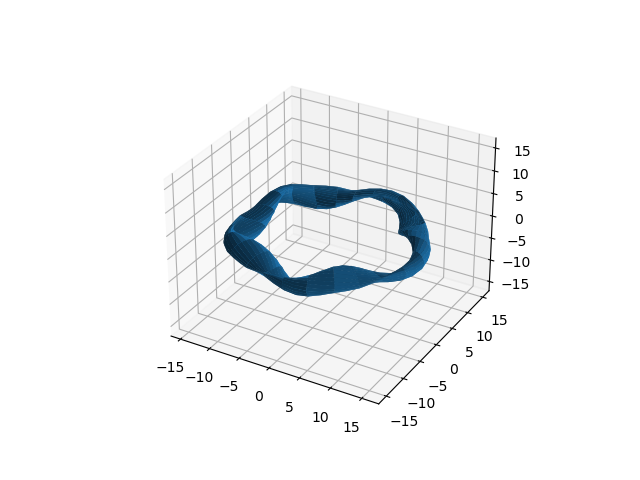

In [28]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf.plot(ax=ax, close=True)
for c in full_curves:
    c.plot(ax=ax, show=False)

# Output and plots

In [29]:
from pystellplot.Paraview import coils_to_vtk, surf_to_vtk
from simsopt.field import compute_fieldlines, LevelsetStoppingCriterion, SurfaceClassifier, plot_poincare_data

In [30]:
coils_to_vtk( coils, 'coils_stage_2' )
surf_to_vtk( 'surf_stage_2', bs, surf )

In [31]:
vmec_surf_1 = SurfaceRZFourier.from_wout('wout_ku5_v444_b586.nc') # Expanded vmec surface
vmec_surf_1.extend_via_normal(0.1)

In [32]:
nfieldlines = 10
tmax_fl = 5000
degree = 6
Rmaj = v.boundary.major_radius()
r0 = v.boundary.minor_radius()

def trace_fieldlines(bfield):
    # Set up initial conditions - 
    R0 = np.linspace(14, 15, nfieldlines)
    Z0 = np.zeros(nfieldlines)
    phis = [(i/4)*(2*np.pi/nfp) for i in range(4)]
    fieldlines_tys, fieldlines_phi_hits = compute_fieldlines(
        bfield, R0, Z0, tmax=tmax_fl, tol=1e-12,
        phis=phis, stopping_criteria=[])

    plot_poincare_data(
        fieldlines_phi_hits, phis, 
        'poincare_fieldline.png', 
        dpi=150,surf=v.boundary,mark_lost=False
    )
    return fieldlines_phi_hits

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

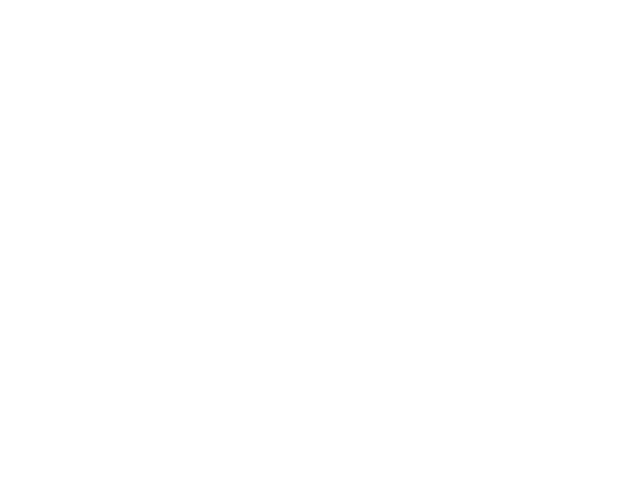

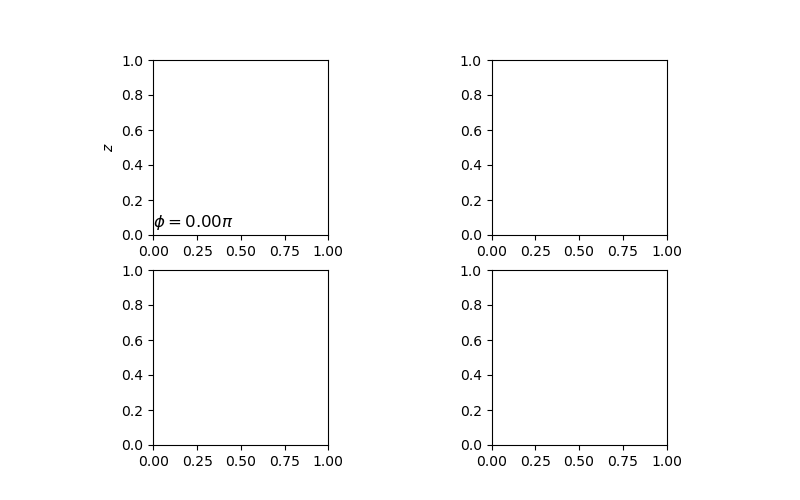

In [33]:
hits = trace_fieldlines(bs)

In [26]:
bs.B()

array([[-0.00104479, -0.00014534,  0.00117981]])